In [1]:
from MED.modeling.modeling_utils import retrieve_results_mlflow
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, jaccard_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
#This code ensembles the predictions of Simple CNN trained on video data and kinematics data (separately) using soft voting.

#Set up variables
run_id_video = "705d4490b0a642e1a9c231fdc0eb3bdf"
run_id_kinematics = "f4c962c1b73045d2aa1860a16abbac17"

outs = ['1Out', '2Out', '3Out', '4Out', '5Out']
setting = 'LOSO'

exp_kwargs = {
    'model_name': "SimpleCNN",
    'dataset_type': "frame",
    'save_local': False}

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [3]:
#Retrieve results for video data
video_f1_train, video_f1_test, video_acc_train, video_acc_test, video_jaccard_train, video_jaccard_test, video_cm_train, video_cm_test, \
                test_all_preds_video, test_all_probs_video, test_all_labels_video, test_all_labels_specific_video,test_all_gest_labels_video, test_all_subjects_video = retrieve_results_mlflow(outs=outs,
                                                                                                                   setting=setting,
                                                                                                                   exp_kwargs=exp_kwargs,
                                                                                                                   run_id=run_id_video)

#Retrieve results for kinematics data
kinematics_f1_train, kinematics_f1_test, kinematics_acc_train, kinematics_acc_test, kinematics_jaccard_train, kinematics_jaccard_test, kinematics_cm_train, kinematics_cm_test, \
                test_all_preds_kinematics, test_all_probs_kinematics, test_all_labels_kinematics, test_all_labels_specific_kinematics, test_all_gest_labels_kinematics, test_all_subjects_kinematics = retrieve_results_mlflow(outs=outs,
                                                                                                                   setting=setting,
                                                                                                                   exp_kwargs=exp_kwargs,
                                                                                                                   run_id=run_id_kinematics)

In [20]:
#Check that global error labels (final position of vector) match specific labels
print(len(test_all_labels_kinematics['5Out']), len(test_all_labels_specific_kinematics['5Out']))

for out in outs:
    for i in range(len(test_all_labels_kinematics[out])):
        if test_all_labels_kinematics[out][i][-1] != test_all_labels_specific_kinematics[out][i]:
            print(f"Mismatch at index {i}: {test_all_labels_kinematics[out][i][-1]} != {test_all_labels_specific_kinematics[out][i]}")

        #Check that if global error label is 1 (position -1), at least one specific label is also 1
        if test_all_labels_kinematics[out][i][-1] == 1 and test_all_labels_kinematics[out][i][:-1].sum() == 0:
            print(f"Global error label is 1 but no specific labels are 1 at index {i}")

640 640


In [15]:
def check_subjects_gestures_labels(outs, subjects_video, subjects_kinematics, gestures_video, gestures_kinematics, labels_video, labels_kinematics):
    
    """
    Check if subjects and gestures match between video and kinematics data.
    Raises ValueError if there is a mismatch.
    """

    for out in outs:
        if out not in subjects_video or out not in subjects_kinematics:
            raise ValueError(f"Output {out} not found in subjects data.")
        if out not in gestures_video or out not in gestures_kinematics:
            raise ValueError(f"Output {out} not found in gestures data.")
        
        subjects_video_fold = np.array(subjects_video[out])
        subjects_kinematics_fold = np.array(subjects_kinematics[out])
        gestures_video_fold = np.array(gestures_video[out])
        gestures_kinematics_fold = np.array(gestures_kinematics[out])
        labels_video_fold = np.array(labels_video[out])
        labels_kinematics_fold = np.array(labels_kinematics[out])

        if not np.array_equal(subjects_video_fold, subjects_kinematics_fold):
            raise ValueError(f"Subjects do not match for output {out}: {subjects_video_fold} vs {subjects_kinematics_fold}")
        elif not np.array_equal(gestures_video_fold, gestures_kinematics_fold):
            raise ValueError(f"Gestures do not match for output {out}: {gestures_video_fold} vs {gestures_kinematics_fold}")
        elif not np.array_equal(labels_video_fold, labels_kinematics_fold):
            raise ValueError(f"Labels do not match for output {out}: {labels_video_fold} vs {labels_kinematics_fold}")
        else:
            print(f"Subjects and gestures match for output {out}.")

    

#Check if subjects and gestures match
check_subjects_gestures_labels(outs= outs, 
                             subjects_video=test_all_subjects_video, 
                             subjects_kinematics=test_all_subjects_kinematics, 
                             gestures_video=test_all_gest_labels_video, 
                             gestures_kinematics=test_all_gest_labels_kinematics,
                            labels_video=test_all_labels_specific_video,
                            labels_kinematics=test_all_labels_specific_kinematics)

Subjects and gestures match for output 1Out.
Subjects and gestures match for output 2Out.
Subjects and gestures match for output 3Out.
Subjects and gestures match for output 4Out.
Subjects and gestures match for output 5Out.


Shape of concatenated predictions: (4252,)
Shape of concatenated labels: (4252,)


,Accuracy,F1 Score,Jaccard Index
Ensemble,0.675917,0.716811,0.558616


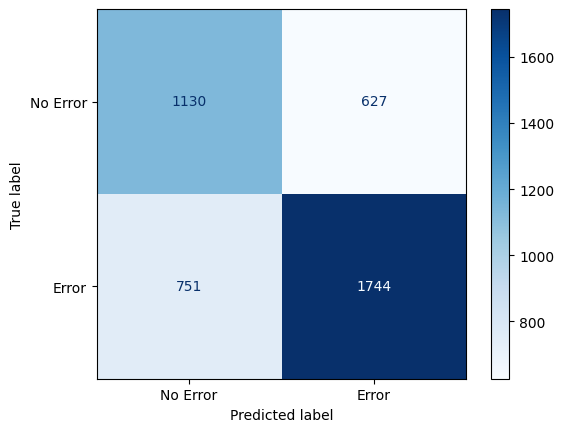

In [16]:
#Ensemble predictions per fold (out) using soft voting
ensemble_preds = {}
video_preds = {}
kinematics_preds = {}
true_labels = {}
ensemble_cm = np.empty((2,2))
results_df = pd.DataFrame(columns = ['Accuracy', 'F1 Score', 'Jaccard Index'])

for out in outs:
    probs_video = np.array(test_all_probs_video[out])
    probs_kinematics = np.array(test_all_probs_kinematics[out])
    
    true_labels[out] = np.array(test_all_labels_specific_video[out]) 
    video_preds[out] = (probs_video >= 0.5).astype(int)  
    kinematics_preds[out] = (probs_kinematics >= 0.5).astype(int)
    
    #Soft voting of binary classification. Probs represent the probabilities of the positive class.
    ensemble_probs = (probs_video + probs_kinematics) / 2
    ensemble_preds[out] = (ensemble_probs >= 0.5).astype(int)

#Get single np.array for preds and labels
preds_concat = np.concatenate(list(ensemble_preds.values()))
labels_concat = np.concatenate(list(true_labels.values()))

print(f"Shape of concatenated predictions: {preds_concat.shape}")
print(f"Shape of concatenated labels: {labels_concat.shape}")

#Calculate metrics
ensemble_f1 = f1_score(labels_concat, preds_concat, average='binary')
ensemble_acc = accuracy_score(labels_concat, preds_concat)
ensemble_jaccard = jaccard_score(labels_concat, preds_concat, average='binary')

#Calculate confusion matrix
ensemble_cm = confusion_matrix(labels_concat, preds_concat)
results_df.loc['Ensemble'] = [ensemble_acc, ensemble_f1, ensemble_jaccard]

#Print results
display(results_df)

#Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=ensemble_cm, display_labels=['No Error', 'Error']).plot(cmap='Blues')

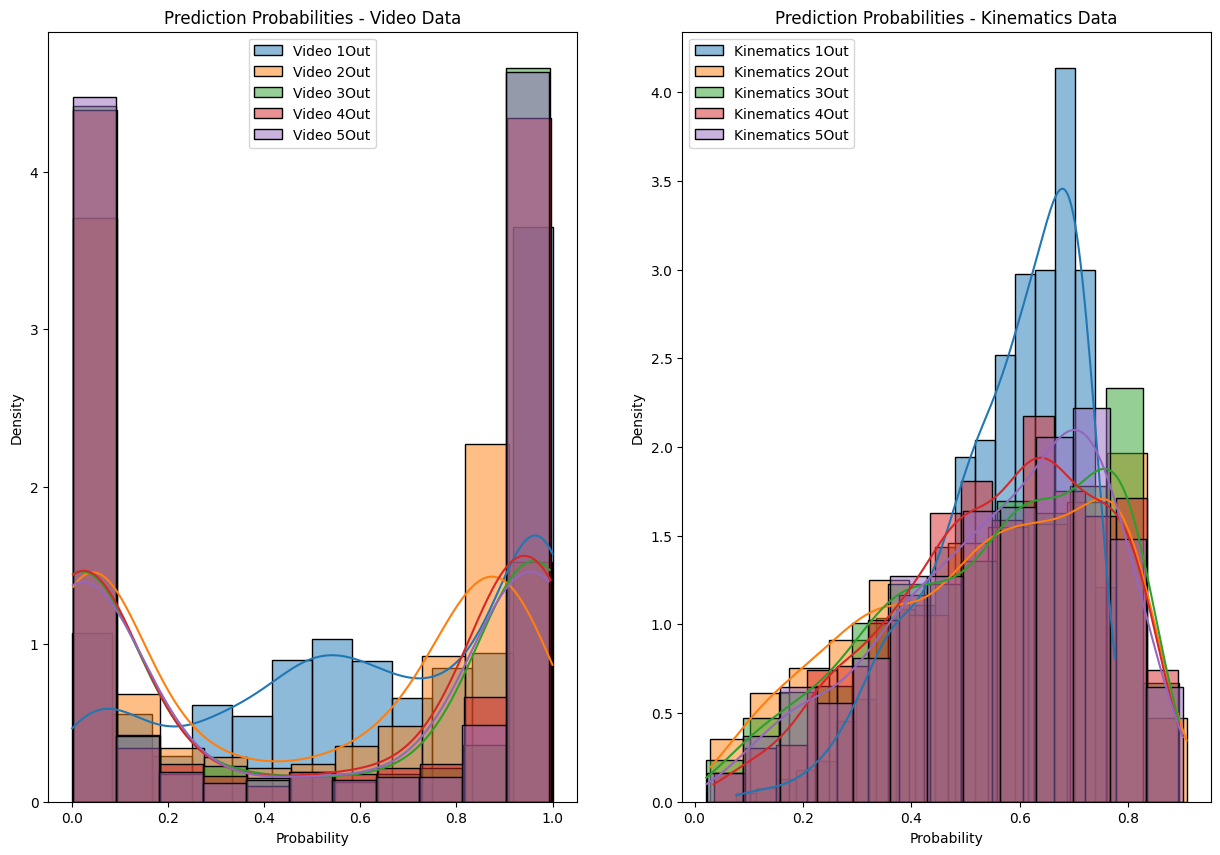

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plot distribution of prediction probabilities per folds
#2 columns (video, kinematics) and 5 columns (outs)
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

for out in outs:
    sns.histplot(test_all_probs_video[out], label=f'Video {out}', kde=True, stat='density', fill=True)
plt.title('Prediction Probabilities - Video Data')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
for out in outs:
    sns.histplot(test_all_probs_kinematics[out], label=f'Kinematics {out}', kde=True, stat='density', fill=True)
plt.title('Prediction Probabilities - Kinematics Data')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()

In [18]:
#Compute percentage of overlap between video and kinematics predictions per fold
overlaps = {}

for out in outs:
    video_preds_fold = np.array(video_preds[out])
    kinematics_preds_fold = np.array(kinematics_preds[out])
    true_labels_fold = np.array(true_labels[out])
    
    count_total = 0
    count_overlap = 0
    correct_inside_overlap = 0
    for i in range(len(video_preds_fold)):
        if video_preds_fold[i] == kinematics_preds_fold[i]:
            count_overlap += 1
            if video_preds_fold[i] == true_labels_fold[i]:
                correct_inside_overlap += 1

        count_total += 1

    overlap_percentage = (count_overlap / count_total) * 100
    correct_inside_overlap = (correct_inside_overlap / count_overlap) if count_overlap > 0 else 0
    print(f"Overlap for {out}: {overlap_percentage:.2f}% (Correct inside overlap: {correct_inside_overlap:.2f})")
    overlaps[out] = overlap_percentage

    

Overlap for 1Out: 63.36% (Correct inside overlap: 0.78)
Overlap for 2Out: 67.78% (Correct inside overlap: 0.66)
Overlap for 3Out: 66.33% (Correct inside overlap: 0.69)
Overlap for 4Out: 63.68% (Correct inside overlap: 0.77)
Overlap for 5Out: 62.19% (Correct inside overlap: 0.78)
